In [4]:
# import necessary modules for data analysis and visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
patient = pd.read_csv('./data/sim_av_patient.csv', delimiter=',')
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


## About this table
This table contains 12 columns, which are about the synthetic patients' demographic information and vital status, as well as death cause of those who are deceased. The columns are:
- Patient ID
- Sex
- Link Number (allows linkeage to another table)
- Ethnicity
- Death Cause Code (1A, 1B, 1C, 2, Underlying)
- Death Location Code
- Vital Status
- Vital Status Date

There are 1,322,100 entries in this table.

In [6]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322100 entries, 0 to 1322099
Data columns (total 12 columns):
PATIENTID                    1322100 non-null int64
SEX                          1322100 non-null int64
LINKNUMBER                   1322100 non-null int64
ETHNICITY                    1192249 non-null object
DEATHCAUSECODE_1A            330280 non-null object
DEATHCAUSECODE_1B            98085 non-null object
DEATHCAUSECODE_1C            18106 non-null object
DEATHCAUSECODE_2             141982 non-null object
DEATHCAUSECODE_UNDERLYING    327910 non-null object
DEATHLOCATIONCODE            330381 non-null object
NEWVITALSTATUS               1322100 non-null object
VITALSTATUSDATE              1322100 non-null object
dtypes: int64(3), object(9)
memory usage: 121.0+ MB


## Demographic Information

[Ethnicity Category Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)

In [7]:
# Group the data by sex and ethnicity to see the demographic information of patients.
group_a = patient.groupby(['SEX', 'ETHNICITY' ]).count()

m_ethnicity = group_a['PATIENTID'][0:20]
m_labels = [x[1] for x in m_ethnicity.index]
m_non_white = m_ethnicity.drop(labels=(1, 'A'))
m_non_white_labels = [x[1] for x in m_non_white.index]

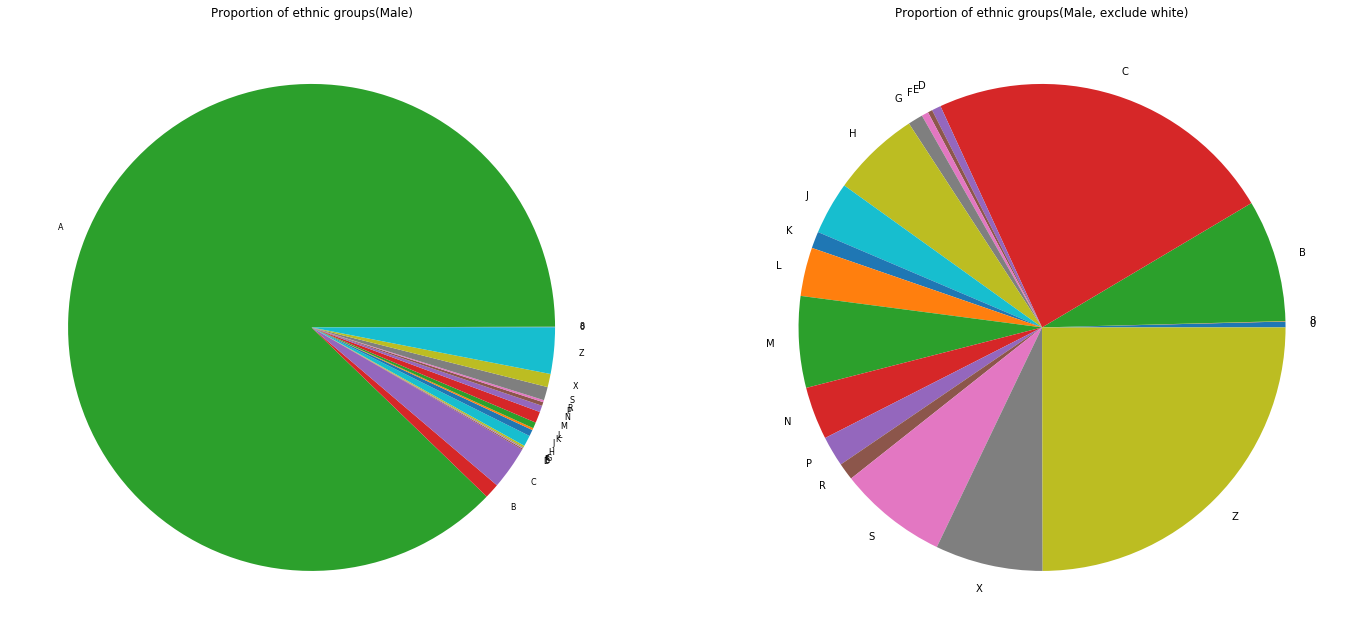

In [8]:
fig1, ax1 = plt.subplots(1, 2, figsize=(24, 24))
ax1[0].pie(m_ethnicity, labels=m_labels, textprops={'fontsize': 8})
ax1[1].pie(m_non_white, labels=m_non_white_labels)
ax1[0].set_title('Proportion of ethnic groups(Male)')
ax1[1].set_title('Proportion of ethnic groups(Male, exclude white)')

plt.show()


In [9]:
fm_ethnicity = group_a['PATIENTID'][21:40]
fm_labels = [x[1] for x in fm_ethnicity.index]
fm_non_white = fm_ethnicity.drop(labels=(2, 'A'))
fm_non_white_labels = [x[1] for x in fm_non_white.index]

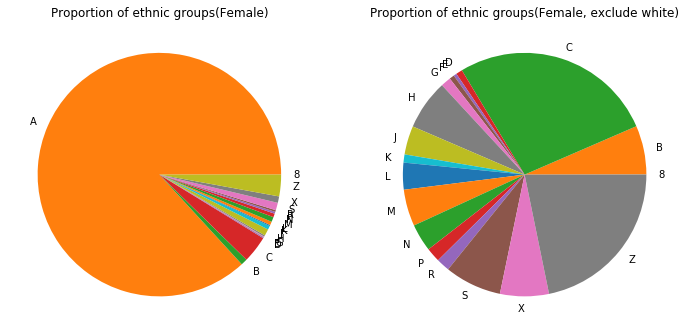

In [10]:
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 12))
ax2[0].pie(fm_ethnicity, labels=fm_labels)
ax2[1].pie(fm_non_white, labels=fm_non_white_labels)
ax2[0].set_title('Proportion of ethnic groups(Female)')
ax2[1].set_title('Proportion of ethnic groups(Female, exclude white)')

plt.show()

In [11]:
group_b = patient.groupby('DEATHCAUSECODE_1A').count()
# group_b
patient['DEATHCAUSECODE_1A'].value_counts()

C349                   47786
J189                   15561
C259                   13568
C798                   13547
J180                   12394
                       ...  
K559,I489,I119,I259        1
C793,C780,C787,C788        1
J984,A419                  1
C349,C787,C795,C779        1
P832                       1
Name: DEATHCAUSECODE_1A, Length: 6564, dtype: int64

## Reference
[Ethnicity Category Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)